This file contains python code to check the hypothesis testing

In [1]:
RUN_PYTHON_SCRIPT = False
#OUTLIER_IDXS = dict(AD=[], ctrl=[])
OUTLIER_IDXS = dict(AD=[49], ctrl=[14, 19, 30, 38])
SAVED_FOLDER = "real_data_40_withN_nooutliers"
DATA = ["AD88_PSD_all.pkl", "Ctrl92_PSD_all.pkl"]

['AD88_PSD_all.pkl', 'Ctrl92_PSD_all.pkl']

In [2]:
import sys
sys.path.append("../mypkg")


In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number
import itertools

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
from IPython.display import display
from joblib import Parallel, delayed

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import importlib
import optimization.opt
importlib.reload(optimization.opt)

<module 'optimization.opt' from '/data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/optimization/opt.py'>

In [5]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_covs, gen_simu_psd, gen_simu_ts
from hdf_utils.fns import fn1, fn2, fn3, fn4, fn5, zero_fn
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_linear
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_basis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.one_step_opt import OneStepOpt
from optimization.cross_validation import CV_err_linear_fn
from optimization.opt import optimization
from penalties.scad_pen import SCAD
from models.linear_model import LinearModel

from joblib import Parallel, delayed

In [6]:
plt.style.use(FIG_ROOT/"base.mplstyle")

In [7]:
torch.set_default_tensor_type(torch.DoubleTensor)
def_dtype = torch.get_default_dtype()

torch.float64

# Load  data and prepare

In [9]:
data_root = DATA_ROOT/"AD_vs_Ctrl_PSD/";
AD_PSD = load_pkl(data_root/DATA[0]);
ctrl_PSD = load_pkl(data_root/DATA[1]);
if not isinstance(AD_PSD, dict):
    tmp1 = AD_PSD
    tmp2 = ctrl_PSD
    AD_PSD = edict()
    AD_PSD.PSDs = tmp1
    AD_PSD.freqs = np.arange(1, 41)
    ctrl_PSD = edict()
    ctrl_PSD.PSDs = tmp2
    ctrl_PSD.freqs = np.arange(1, 41)
baseline = pd.read_csv(data_root/"AllDataBaselineOrdered_r_ncpt.csv");
baseline["Gender_binary"] = baseline["Gender"].apply(lambda x: 0 if x=="female" else 1);
baseline["Grp_binary"] = baseline["Grp"].apply(lambda x: 1 if x=="AD" else 0);

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../data/AD_vs_Ctrl_PSD/AD88_PSD_all.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../data/AD_vs_Ctrl_PSD/Ctrl92_PSD_all.pkl


In [10]:
# The outlier idxs to rm
outlier_idxs = np.concatenate([OUTLIER_IDXS["AD"], len(AD_PSD.PSDs)+np.array(OUTLIER_IDXS["ctrl"])])
outlier_idxs = outlier_idxs.astype(int)

# make PSD in dB and std 
raw_X = np.concatenate([AD_PSD.PSDs, ctrl_PSD.PSDs]); #n x d x npts
X_dB = np.log10(raw_X);
X = (X_dB - X_dB.mean(axis=-1, keepdims=1))/X_dB.std(axis=-1, keepdims=1);

Y = np.array(baseline["MMSE"])[:X.shape[0]];

sel_cov = ["Gender_binary", "MEG_Age"]
Z_raw = np.array(baseline[sel_cov])[:X.shape[0]];

grp_idxs = np.array(baseline["Grp"])[:X.shape[0]];

# remove outliers
X = np.delete(X, outlier_idxs, axis=0)
Y = np.delete(Y, outlier_idxs, axis=0)
Z_raw = np.delete(Z_raw, outlier_idxs, axis=0)
grp_idxs = np.delete(grp_idxs, outlier_idxs, axis=0)


#remove nan
keep_idx = ~np.bitwise_or(np.isnan(Y), np.isnan(Z_raw.sum(axis=1)));
X = X[keep_idx];
Y = Y[keep_idx]
Z_raw = Z_raw[keep_idx]
grp_idxs = grp_idxs[keep_idx]

Z_raw_mean = Z_raw.mean(axis=0, keepdims=1);
Z_raw_std = Z_raw.std(axis=0, keepdims=1);
# we do not need to std binary
Z_raw_mean[0, :1] = 0
Z_raw_std[0, :1] = 1
Z = (Z_raw-Z_raw_mean)/Z_raw_std;
Z = np.concatenate([np.ones((Z.shape[0], 1)), Z], axis=1); # add intercept

#Y = (Y-Y.mean())/Y.std()

print(X.shape, Y.shape, Z.shape)

all_data = edict()
all_data.X = torch.tensor(X)
all_data.Y = torch.tensor(Y)
all_data.Z = torch.tensor(Z)

(152, 68, 40) (152,) (152, 3)


In [11]:
# atlas
rois = np.loadtxt(DATA_ROOT/"dk68_utils/ROI_order_DK68.txt", dtype=str);

# Param and fns

## Params

In [12]:
np.random.seed(0)
paras = edict(def_paras.copy())

# Others
paras.num_rep = 1000 
paras.freqs = AD_PSD.get("freqs", np.arange(1, 41)).reshape(-1);
paras.SIS_ratio = 1 # the ratio to keep with SIS procedure
paras.svdinv_eps_Q = 1
paras.svdinv_eps_Psi = 0.999
paras.sigma2 = 1
paras.init_noise_sd = 10

# multiple sets of params
paras.ns = [100, 300, 900, 2700, 8100, 24300]
paras.can_lams = [1e-1, 3e-1, 1e0, 3e0, 9e0, 3e1]
paras.can_Ns = [5, 10, 15, 20]

# generating dataset
paras.n = X.shape[0] # num of data obs to be genareted
paras.npts = X.shape[2] # num of pts to evaluate X(s)
paras.d = X.shape[1]# num of ROIs
paras.q = Z.shape[1] # num of other covariates

# b-spline
paras.x = np.linspace(0, 1, paras.npts)
#paras.N = 8 # int(3*paras.n**(1/paras.ord/2)) # num of basis for bsp
#paras.basis_mat = torch.tensor(obt_bsp_basis_Rfn_wrapper(paras.x, paras.N, paras.ord)).to(torch.get_default_dtype())
#assert paras.N == paras.basis_mat.shape[1]
#print(f"The number of B-spline basis is {paras.N:.0f}.")

# optimization
paras.Rmin = 10000 # just make it large, do not let it play the main role (on Jun 12, 2023)
paras.Rfct = 2
#without loss of generality, we assume the idxs in M is the first m betas
paras.num_cv_fold = 5
#paras.stop_cv = 5e-5
paras.stop_cv = 5e-4
#paras.max_iter = 10000
paras.max_iter = 2000
paras.sel_idx = np.arange(1, paras.d) # M^c set, 

# hypothesis test
paras.M_idxs = np.delete(np.arange(paras.d), paras.sel_idx) # the M set
paras.Cmat = np.eye(len(paras.M_idxs)) # Cmat \times beta_M(s), r x m
paras.r, paras.m = paras.Cmat.shape
paras.t_vec = np.zeros(paras.Cmat.shape[0]) # t vec, typically it is zero vector


In [13]:
paras.save_dir = RES_ROOT/SAVED_FOLDER
if not paras.save_dir.exists():
    paras.save_dir.mkdir()

In [14]:
bands_cut = edict()
bands_cut.delta = [1, 4]
bands_cut.theta = [4, 8]
bands_cut.alpha = [8, 12]
bands_cut.beta = [12, 35]
bands_cut.pts = [4, 8, 12, 35]

cut_pts = np.abs(paras.freqs.reshape(-1, 1) - bands_cut.pts).argmin(axis=0)

array([ 3,  7, 11, 34])

## Fns

In [15]:
def MS2idxs(q, N, MS_unions):
    """This fn is to return the idxs to keep in mat Q, Sigma and vec Theta
    """
    idxs_all = [np.arange(0, q)]
    for cur_idx in MS_unions:
        idxs_all.append(np.arange(q+cur_idx*N, q+(cur_idx+1)*N))
    idxs_all = np.concatenate(idxs_all)
    return idxs_all

In [16]:
def get_Amat(k, paras):
    """Get A matrix for hypothesis test
        k: Num of elements in S
        paras: parameters
                required: N, Cmat, m, q
    """
    _paras = edict(paras.copy())
    
    part1 = np.kron(_paras.Cmat, np.eye(_paras.N))
    part2 = np.zeros((_paras.m*_paras.N, _paras.q+(_paras.m+k)*_paras.N))
    part2[:, _paras.q:(_paras.q+_paras.m*_paras.N)] = np.eye(_paras.m*_paras.N)
    A = part1 @ part2
    return A

In [17]:
def obt_test_stat(model, est_alp, est_Gam, paras):
    """
    Obtain the test statistics via the estimator.

    Args:
        model: The model you used, LinearModel or LogisticModel
        est_alp: Estimated alp parameters
        est_Gam: Estimated Gam parameters
        paras: Dictionary containing parameters for the test
            - N: Number of samples
            - M_idxs: Indices of the M set
            - q: Number of ROIs
            - svdinv_eps_Q: Threshold for SVD inverse of Q matrix
            - svdinv_eps_Psi: Threshold for SVD inverse of Psi matrix
            - n: Number of observations

    Returns:
        T_v: Test statistic value
    """
    _paras = edict(paras.copy())
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    Q_mat = -model.log_lik_der2(est_alp, est_Gam)
    model.log_lik_der1(est_alp, est_Gam);
    Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0) 
    # minus sign canceled
    
    
    # obtain the idxs to keep for test
    nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
    MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
    keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
    
    # A mat
    k = len(np.setdiff1d(nonzero_idxs, _paras.M_idxs))
    Amat = torch.Tensor(get_Amat(k, _paras))
    
    # calculate Test stats
    Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
    if _paras.svdinv_eps_Q >= 1:
        Q_mat_part_inv = torch.pinverse(Q_mat_part)
    else:
        Q_mat_part_inv = svd_inverse(Q_mat_part, _paras.svdinv_eps_Q)
    
    Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
    Psi = Amat @ Q_mat_part_inv @ Sig_mat_part @ Q_mat_part_inv @ Amat.T
    
    T_p1 = Amat @ est_theta[keep_idxs_test]
    if _paras.svdinv_eps_Psi >= 1:
        Psi_inv = torch.pinverse(Psi)
    else:
        Psi_inv = svd_inverse(Psi, _paras.svdinv_eps_Psi)
    T_v = T_p1 @ Psi_inv @ T_p1 * _paras.n 
    return T_v

# Run

In [18]:
def move_elements_to_front(indices, vec=torch.arange(68)):
    if not isinstance(vec, torch.Tensor):
        vec = torch.tensor(vec)
    
    selected_elements = vec[indices]
    
    mask = torch.ones(vec.size(0), dtype=bool)
    mask[indices] = False
    
    remaining_elements = vec[mask]
    
    result = torch.cat((selected_elements.sort().values, remaining_elements.sort().values))
    
    return result
def _run_fn(seed, lam, N, roi_idxs=[0], paras=None):
    torch.set_default_tensor_type(torch.DoubleTensor)
    cur_data = edict()
    cur_data.X = all_data.X.clone()
    cur_data.Y = all_data.Y.clone()
    cur_data.Z = all_data.Z.clone()
    
    cur_data.X = cur_data.X[:, move_elements_to_front(roi_idxs), :]
    
    
    torch.set_default_tensor_type(torch.DoubleTensor)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    _paras = edict(paras.copy())
    fil_name = _paras.save_dir/f"seed-{seed:.0f}_lam-{lam*1000:.0f}_N-{N:.0f}_roi-{'-'.join(map(str, roi_idxs))}.pkl";
    if fil_name.exists():
        return load_pkl(fil_name)
    
    _paras.lam = lam
    _paras.seed = seed
    _paras.Rv = _paras.Rfct * _paras.Rmin
    _paras.roi_idxs = roi_idxs
    _paras.N = N 
    _paras.basis_mat = torch.tensor(obt_bsp_basis_Rfn_wrapper(_paras.x, _paras.N, _paras.ord)).to(torch.get_default_dtype())
    assert _paras.N == _paras.basis_mat.shape[1]
    est_Gam_full = torch.zeros(_paras.N, _paras.d).to(torch.get_default_dtype());

    
    
    # do sure independent screening for dim reduction
    if _paras.SIS_ratio < 1:
        keep_idxs, _  = SIS_linear(cur_data.Y, cur_data.X, cur_data.Z, _paras.SIS_ratio, _paras, ridge_pen=0)
    else:
        keep_idxs = _paras.sel_idx
    M_idxs = np.delete(np.arange(_paras.d), _paras.sel_idx)
    _paras.keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
        
    _paras.sel_idx_SIS = np.where(np.array([keep_idx in _paras.sel_idx for keep_idx in _paras.keep_idxs]))[0]
    _paras.d_SIS = len(_paras.keep_idxs)
    
    cur_data_SIS = edict(cur_data.copy())
    cur_data_SIS.X = cur_data.X[:, _paras.keep_idxs, :]
    
    
    alp_init =  torch.randn(_paras.q)*_paras.init_noise_sd
    Gam_init = torch.randn(_paras.N, _paras.d_SIS)*_paras.init_noise_sd
    theta_init = torch.cat([alp_init, col_vec_fn(Gam_init)/np.sqrt(_paras.N)])
    rhok_init = torch.randn(_paras.d_SIS*_paras.N)
        
    model = LinearModel(Y=cur_data_SIS.Y, 
                        X=cur_data_SIS.X, 
                        Z=cur_data_SIS.Z, 
                        basis_mat=_paras.basis_mat, 
                        sigma2=_paras.sigma2)
    # 3e0
    pen = SCAD(lams=_paras.lam, a=_paras.a,  sel_idx=_paras.sel_idx_SIS)
        
    
    main_res = optimization(model=model, 
                            penalty=pen, 
                            inits=[alp_init, Gam_init, theta_init, rhok_init],
                            is_prg=True,
                            save_paras=False,    
                            input_paras=_paras)
    
    if False:
        cv_errs = CV_err_linear_fn(data=cur_data_SIS, 
                                   penalty=pen, 
                                   num_cv_fold=_paras.num_cv_fold,
                                   inits=[alp_init, Gam_init, theta_init, rhok_init], 
                                   is_prg=False, 
                                   save_paras=False,    
                                   input_paras=_paras)
    else:
        cv_errs = None
    
    opt = main_res[0]
    est_Gam = opt.Gamk
    est_alp = opt.alpk
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    est_Gam_full[:, _paras.keep_idxs] = est_Gam.clone()
    #T_v = None
    T_v = obt_test_stat(model, est_alp, est_Gam, _paras)
    save_pkl(fil_name, (main_res, cv_errs, T_v, _paras), verbose=False)
    return main_res, cv_errs, T_v, _paras

In [19]:
paras.stop_cv = 5e-5
paras.max_iter = 20000
paras.sel_idx = np.arange(1, paras.d) # M^c set, 
paras.Rfct = 10

# hypothesis test
paras.M_idxs = np.delete(np.arange(paras.d), paras.sel_idx) # the M set
paras.Cmat = np.eye(len(paras.M_idxs)) # Cmat \times beta_M(s), r x m
paras.r, paras.m = paras.Cmat.shape
paras.t_vec = np.zeros(paras.Cmat.shape[0]) # t vec, typically it is zero vector

paras.lams = [0.1, 0.5, 1, 2, 2.5, 3, 4, 5, 6, 12, 24]
paras.Ns = [6, 8, 10, 12, 14]

roi_idxs_all = np.arange(68);
all_coms = itertools.product(paras.lams, paras.Ns, roi_idxs_all);

In [ ]:
seed = 0
with Parallel(n_jobs=1) as parallel:
    ress = parallel(delayed(_run_fn)(seed, lam, N, [int(roi_idx)], paras) for lam, N, roi_idx 
                    in tqdm(all_coms, total=len(paras.Ns)*len(paras.lams)*68))

# Analysis

In [20]:
import matplotlib.patches as mpatches
from nilearn import plotting
import matplotlib as mpl
from utils.brain_plot import get_bg_data

In [21]:
def _get_sig_bds(lows, ups):
    """Get sig bds based on lows and ups CI bds
    """
    insig_idxs = np.bitwise_and(lows<=0, ups>=0).bool()
    insig_idxs_num = np.where(insig_idxs)[0]
    idxs = np.where(np.diff(insig_idxs_num)>1)[0]
    bds = [(insig_idxs_num[ix], insig_idxs_num[ix+1]) for ix in idxs]
    if insig_idxs_num[0] > 0:
        bds.append((0, insig_idxs_num[0]))
    if insig_idxs_num[-1] < (len(ups)-1):
        bds.append((insig_idxs_num[-1], len(ups)-1))
    bds = sorted(bds, key=lambda x: x[0])
    return bds

In [22]:
def _obt_covmat(res):
    """Calculate the cov mat of the estimate ROI
    """
    _paras = res[-1]
    opt_res = res[0][0]
    
    torch.set_default_tensor_type(torch.DoubleTensor)
    cur_data = edict()
    cur_data.X = all_data.X.clone()
    cur_data.Y = all_data.Y.clone()
    cur_data.Z = all_data.Z.clone()
    
    cur_data.X = cur_data.X[:, move_elements_to_front(_paras.roi_idxs), :]

    
    cur_data_SIS = edict(cur_data.copy())
    cur_data_SIS.X = cur_data.X[:, _paras.keep_idxs, :]
    
        
    model = LinearModel(Y=cur_data_SIS.Y, 
                        X=cur_data_SIS.X, 
                        Z=cur_data_SIS.Z, 
                        basis_mat=_paras.basis_mat, 
                        sigma2=_paras.sigma2)
        
    est_Gam = opt_res.Gamk
    est_alp = opt_res.alpk
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    
    Q_mat = -model.log_lik_der2(est_alp, est_Gam)
    model.log_lik_der1(est_alp, est_Gam);
    Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0) 
    
    
    # obtain the idxs to keep for test
    nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
    MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
    keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
    
    # calculate Test stats
    Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
    if _paras.svdinv_eps_Q >= 1:
        Q_mat_part_inv = torch.pinverse(Q_mat_part)
    else:
        Q_mat_part_inv = svd_inverse(Q_mat_part, _paras.svdinv_eps_Q)
    
    Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
    cov_mat = Q_mat_part_inv @ Sig_mat_part @ Q_mat_part_inv/_paras.n*_paras.N
    
    return cov_mat[_paras.q:(_paras.q+_paras.N), _paras.q:(_paras.q+_paras.N)]

In [23]:

def _brain_plot(vec, cmap="Reds", threshold=None):
    root = DATA_ROOT/"dk68_utils/"
    h = 0.43
    
    XYZsl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_left.txt")
    facesl = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_left.txt").astype(np.int64)
    roi_tmpl = np.loadtxt(root/"brain_tmp_left_DK68.txt");
    bg_datal = get_bg_data(XYZsl, facesl)
    
    XYZsr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_XYZs_right.txt")
    facesr = np.loadtxt(root/"MyBrainMesh_ICBM152_surf_sm20_faces_right.txt").astype(np.int64)
    roi_tmpr = np.loadtxt(root/"brain_tmp_right_DK68.txt");
    bg_datar = get_bg_data(XYZsr, facesr)
    
    # map vec to the template
    vecl = roi_tmpl.copy()
    vecr = roi_tmpr.copy()
    for roi_ix in range(1, 35):
        vecl[roi_tmpl==roi_ix] = vec[roi_ix-1]
        vecr[roi_tmpr==roi_ix] = vec[roi_ix-1+34]
        
    vmin, vmax = np.min(vec), np.max(vec)
    #fig, axs = plt.subplots(2, 2, figsize=[10, 10], subplot_kw={'projection': '3d'})
    fig = plt.figure(figsize=(10, 10))
    # left, bottom, width, height
    # facecolor make the bg  transparent
    ax1 = fig.add_axes([0.1,  0.5, h,  h], projection='3d',  facecolor='none')
    ax2 = fig.add_axes([0.15, 0.1, h,  h], projection='3d',  facecolor='none') 
    ax3 = fig.add_axes([0.5,  0.5, h,  h], projection='3d',  facecolor='none')
    ax4 = fig.add_axes([0.47, 0.1, h,  h], projection='3d',  facecolor='none')  
    
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="lateral", axes=ax1, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal, # TO get the depth of the brain plot
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsl, facesl], vecl, hemi='left', view="medial", axes=ax2, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datal,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="lateral", axes=ax3, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    plotting.plot_surf_roi([XYZsr, facesr], vecr, hemi='right', view="medial", axes=ax4, 
                           bg_on_data=True, darkness=1.5, bg_map=bg_datar,
                           colorbar=False, cmap=cmap, threshold=threshold, 
                           figure=fig, vmin=vmin, vmax=vmax);
    
    fig.text(0.12, 0.30, 'Medial', ha='center', va='center')
    fig.text(0.12, 0.72, 'Lateral', ha='center', va='center')
    fig.text(0.30, 0.87, 'Left', ha='center', va='center')
    fig.text(0.72, 0.87, 'Right', ha='center', va='center')
    plt.suptitle("-log pvalues", fontsize=30)
    
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    fig.colorbar(sm, cax=cbar_ax)
    return fig

In [51]:
def _filname2set(fil):
    """Based on the file name, reture the setting"""
    res = edict()
    for curstr in fil.stem.split("_"):
        rawname, raw_v = curstr.split("-")
        if rawname == "lam":
            res[rawname] = int(raw_v)/1000
        else:
            res[rawname] = int(raw_v)
    return res
tNs = []
tlams = []
for fil in paras.save_dir.glob(f"seed*.pkl"):
    tmp = _filname2set(fil)
    tNs.append(tmp["N"])
    tlams.append(tmp["lam"])
np.sort(np.unique(tNs)),  np.sort(np.unique(tlams))

(array([ 6,  8, 10, 12, 14]),
 array([ 0.1,  0.5,  1. ,  2. ,  3. ,  4. ,  5. ,  6. , 12. , 24. ]))

In [102]:
def _argmin_last2d(arr):
    """
    Find the minimum value positions along the last two dimensions of a 2D array.

    Args:
    arr (numpy.ndarray): Input 2D array.

    Returns:
    tuple: Indices of the minimum values along the last two dimensions.
    """
    arr_reshaped = arr.reshape(arr.shape[0], -1)
    min_positions_linear = np.argmin(arr_reshaped, axis=1)
    min_positions = np.unravel_index(min_positions_linear, arr.shape[1:])
    return min_positions

In [52]:
from scipy.stats import chi2
tmp_fil = list(paras.save_dir.glob(f"seed*.pkl"))[0];
tparas = load_pkl(tmp_fil)[-1];
lams = np.array([0.1, 0.5, 1, 2,  3, 4, 5, 6, 12, 24])
Ns = np.array([6, 8, 10, 12, 14])

chi_df = tparas.r*tparas.N
log_cv = np.log(0.05/68)

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../results/real_data_40_withN_nooutliers/seed-0_lam-2000_N-10_roi-0.pkl


-7.215239978730097

In [53]:
# sel the lams based on the CV errors
errss = []
for roi_ix in trange(68):
    errs_N = []
    for N in Ns:
        errs_lam = []
        for lam in lams:
            fil = paras.save_dir/f"seed-0_lam-{lam*1000:.0f}_N-{N:.0f}_roi-{roi_ix}.pkl"
            res = load_pkl(fil, verbose=False)
            errs_lam.append(res[1])
        errs_N.append(errs_lam)
    errss.append(errs_N)
errss = np.array(errss); #nroi x nN x nlam x nsub
mse_err = np.mean(errss**2, axis=-1);
mae_err = np.mean(np.abs(errss), axis=-1);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [06:14<00:00,  5.50s/it]


In [162]:
save_pkl(RES_ROOT/f"{SAVED_FOLDER}/errss_N_lam.pkl", errss);

Save to /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../results/real_data_40_withN_nooutliers/errss_N_lam.pkl


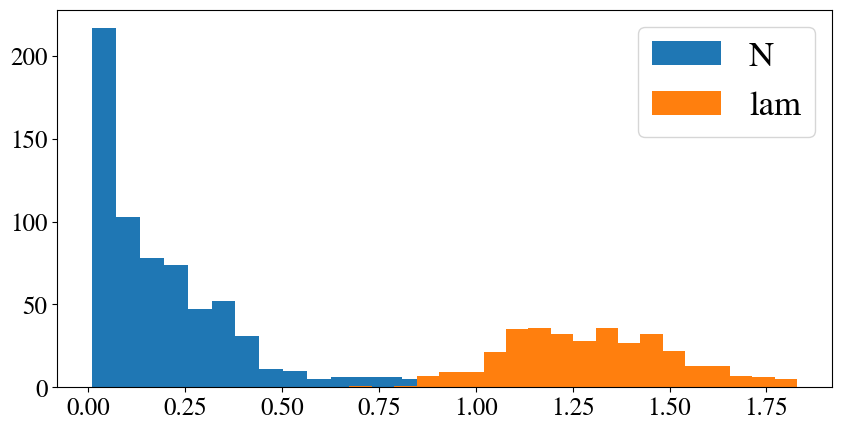

In [81]:
plt.hist(mae_err.std(axis=1).reshape(-1), bins=20, label="N")
plt.hist(mae_err.std(axis=2).reshape(-1), bins=20, label="lam");
plt.legend()

## Select with mae

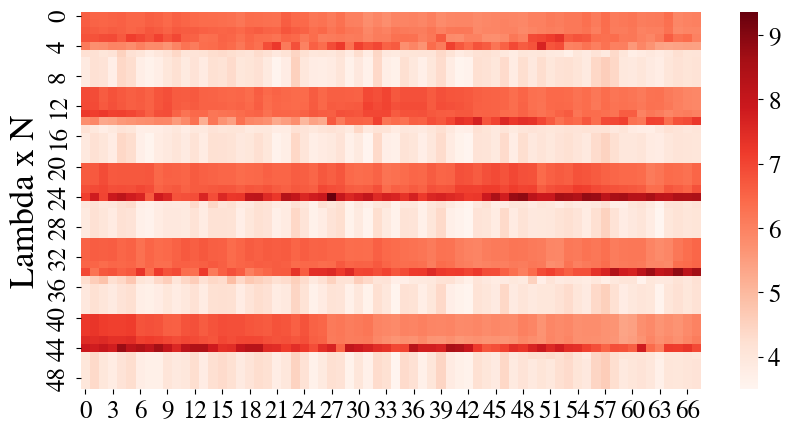

In [105]:
if not RUN_PYTHON_SCRIPT:
    sns.heatmap(mae_err.reshape(68, -1).T, cmap="Reds")
    plt.ylabel("Lambda x N");

In [114]:
min_idxs = _argmin_last2d(mae_err);
sel_Nlams_mae = np.zeros((68, 2))
for roi_ix in range(68):
    sel_Nlams_mae[roi_ix, 0] = Ns[min_idxs[0][roi_ix]]
    sel_Nlams_mae[roi_ix, 1] = lams[min_idxs[1][roi_ix]]

In [115]:
T_vs = []
keep_rois = []
for roi_ix in trange(68):
    idxs = np.concatenate([np.arange(1, roi_ix+1), [0], np.arange(roi_ix+1, 68)])
    errs = []
    N, lam = sel_Nlams_mae[roi_ix]
    fil = paras.save_dir/f"seed-0_lam-{lam*1000:.0f}_N-{N:.0f}_roi-{roi_ix}.pkl"
    res = load_pkl(fil, verbose=False)
    T_vs.append(res[-2].item())
    keep_rois.append((res[0][0].Gamk.norm(dim=0) != 0).numpy().astype(int)[idxs])
keep_rois = np.array(keep_rois)
T_vs = np.array(T_vs);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:06<00:00, 11.32it/s]


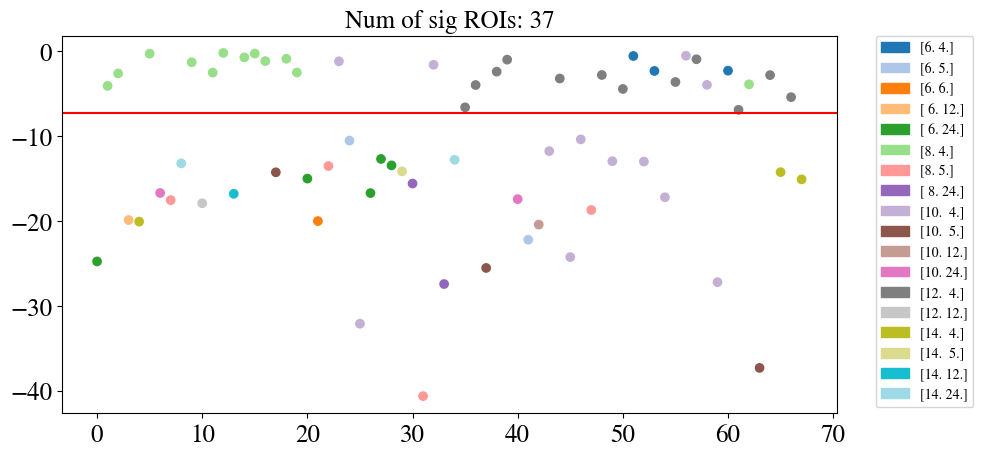

In [144]:
unique_coms = np.unique(sel_Nlams_mae, axis=0)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_coms)));
point_colors = [ colors[np.abs(unique_coms - val).sum(axis=-1)==0].squeeze() for val in sel_Nlams_mae];

log_pvs = chi2.logsf(T_vs, df=chi_df);

plt.title(f"Num of sig ROIs: {np.sum(log_pvs<log_cv):.0f}")
plt.scatter(x=np.arange(68), y=log_pvs, c=point_colors)
plt.axhline(y=log_cv, color="red")

patches = [mpatches.Patch(color=colors[np.abs(unique_coms - val).sum(axis=-1)==0].squeeze(), label=str(val)) for val in unique_coms]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=1, fontsize=10)


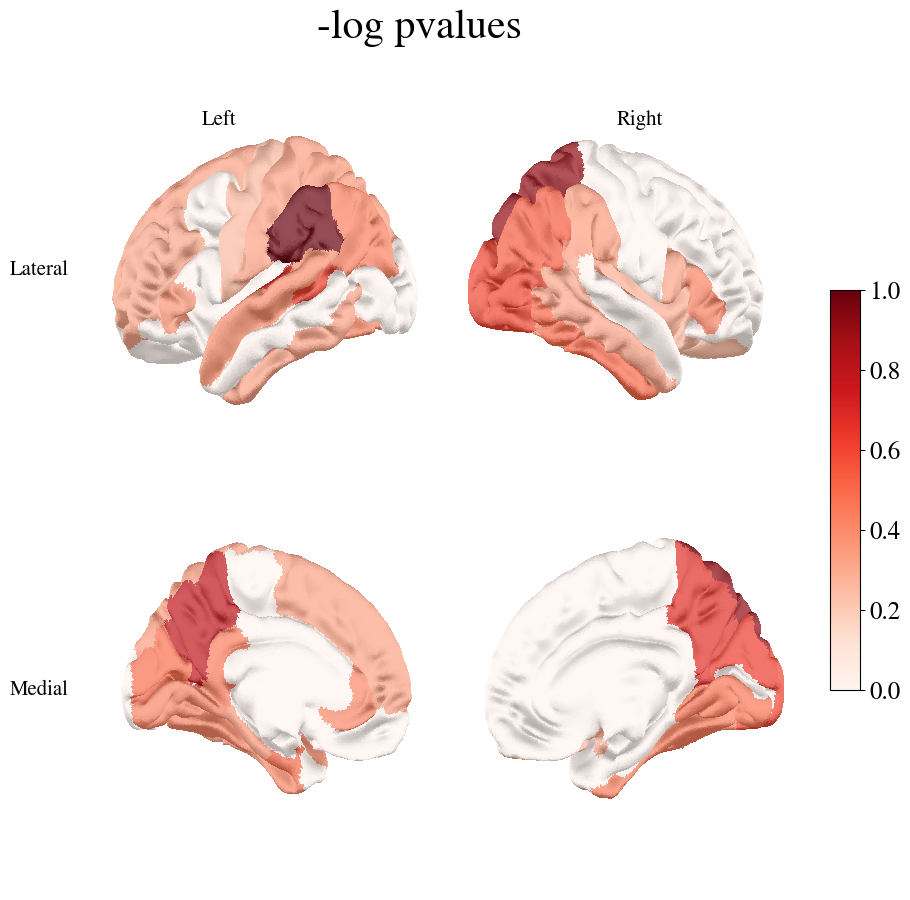

In [140]:
vec = -log_pvs
vec = (vec-vec.min())/(vec.max()-vec.min())
vec[log_pvs>=np.log(0.05/68)] = 0
#vec[log_pvs>=np.sort(log_pvs)[25]] = 0
cmap = "Reds"
fig = _brain_plot(vec, cmap=cmap);
#plt.savefig(FIG_ROOT/f"{SAVED_FOLDER}_pval_brain_plot_mae_more.jpg")

### CI

In [145]:
# select the results
num_sig = np.sum(log_pvs<log_cv)
sorted_idxs = np.argsort(log_pvs);
sig_list = []
for ix in trange(68):
    roi_sel = sorted_idxs[ix];
    fil = paras.save_dir/f"seed-0_lam-{sel_Nlams_mae[roi_sel, 1]*1000:.0f}_N-{sel_Nlams_mae[roi_sel, 0]:.0f}_roi-{roi_sel}.pkl"
    res_sel = load_pkl(fil, verbose=False);
    
    opt_sel = res_sel[0][0];
    paras_sel = res_sel[-1];
    betas_sel = paras_sel.basis_mat @  opt_sel.Gamk;betas_sel.shape
    beta_est = betas_sel[:, 0]
    cov_mat = _obt_covmat(res_sel);
    cov_mat_beta = paras_sel.basis_mat @ cov_mat @ paras_sel.basis_mat.T;
    
    lows = beta_est - np.sqrt(np.diag(cov_mat_beta))*1.96
    ups = beta_est + np.sqrt(np.diag(cov_mat_beta))*1.96
    
    bds = _get_sig_bds(lows, ups)
    sig_list.append(1-np.bitwise_and(lows<=0, ups>=0).numpy())
    
sig_list = np.array(sig_list)
sorted_rois = rois[sorted_idxs]
sorted_pvs = np.exp(log_pvs[sorted_idxs]);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:21<00:00,  3.15it/s]


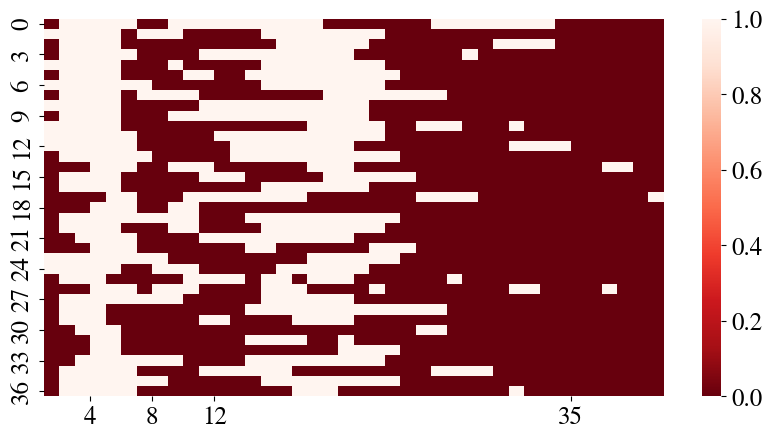

In [146]:
sns.heatmap(sig_list[:num_sig], cmap="Reds_r")
plt.xticks(cut_pts, bands_cut.pts);

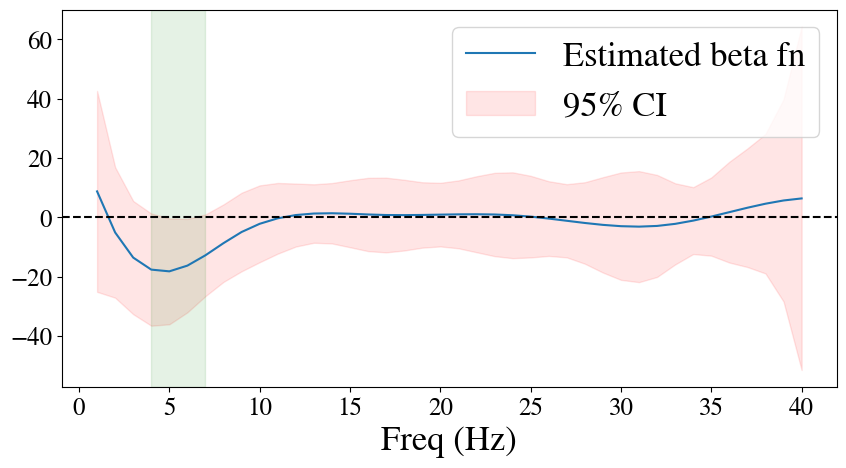

In [150]:
if not RUN_PYTHON_SCRIPT:
    roi_sel = sorted_idxs[-1];
    fil = paras.save_dir/f"seed-0_lam-{sel_Nlams_mae[roi_sel, 1]*1000:.0f}_N-{sel_Nlams_mae[roi_sel, 0]:.0f}_roi-{roi_sel}.pkl"
    res_sel = load_pkl(fil, verbose=False);
    
    opt_sel = res_sel[0][0];
    paras_sel = res_sel[-1];
    betas_sel = paras_sel.basis_mat @  opt_sel.Gamk;betas_sel.shape
    beta_est = betas_sel[:, 0]
    cov_mat = _obt_covmat(res_sel);
    cov_mat_beta = paras_sel.basis_mat @ cov_mat @ paras_sel.basis_mat.T;
    
    lows = beta_est - np.sqrt(np.diag(cov_mat_beta))*1.96
    ups = beta_est + np.sqrt(np.diag(cov_mat_beta))*1.96
    
    bds = _get_sig_bds(lows, ups)
    
    freq_data_sel = all_data.X[:, roi_sel];
    plt.plot(paras.freqs, beta_est, label="Estimated beta fn")
    plt.fill_between(paras.freqs, lows, ups, color="red", alpha=0.1, label="95% CI")
    
    if False:
        freq_data_sel_AD = freq_data_sel[grp_idxs=="AD"].mean(axis=0)
        freq_data_sel_ctrl = freq_data_sel[grp_idxs=="Ctrl"].mean(axis=0)
        plt.plot(paras.freqs, freq_data_sel_AD-freq_data_sel_ctrl, label="AD-Ctrl")
    
    y_min, y_max = plt.ylim()
    for bd in bds: 
        x1, x2 = paras.freqs[bd[0]], paras.freqs[bd[1]]
        plt.fill_betweenx([y_min, y_max], x1=x1, x2=x2, color='green', alpha=0.1)
    plt.axhline(y=0, ls="--", color="black")
    plt.ylim([y_min, y_max])
    plt.xlabel("Freq (Hz)")
    plt.legend()

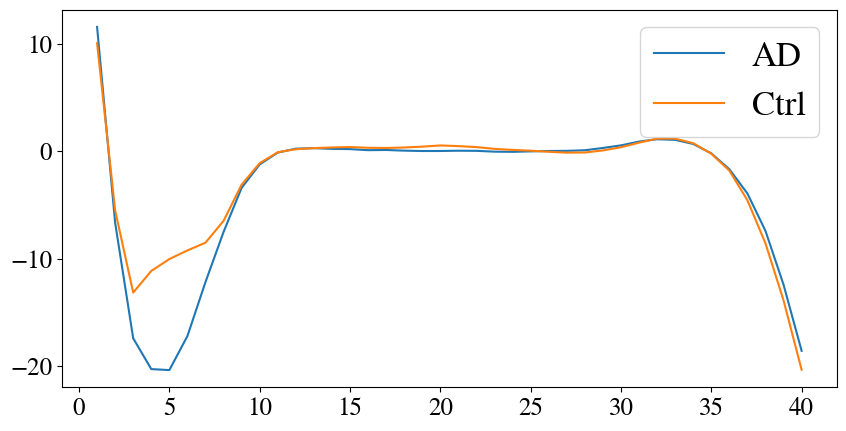

In [151]:
betaxs_sel = freq_data_sel * betas_sel[:, 0];
betaxs_sel_AD = betaxs_sel[grp_idxs=="AD"].mean(axis=0)
betaxs_sel_ctrl = betaxs_sel[grp_idxs=="Ctrl"].mean(axis=0)
plt.plot(paras.freqs, betaxs_sel_AD, label="AD")
plt.plot(paras.freqs, betaxs_sel_ctrl, label="Ctrl")
plt.legend()

## Select with mse

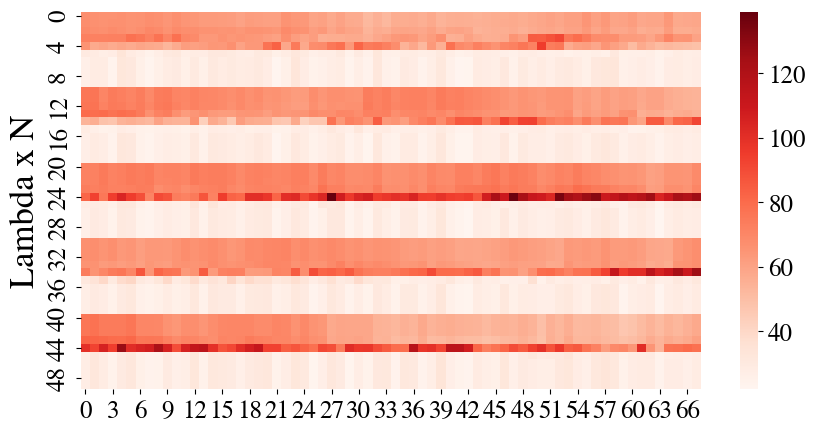

In [152]:
if not RUN_PYTHON_SCRIPT:
    sns.heatmap(mse_err.reshape(68, -1).T, cmap="Reds")
    plt.ylabel("Lambda x N");

In [153]:
min_idxs = _argmin_last2d(mse_err);
sel_Nlams_mse = np.zeros((68, 2))
for roi_ix in range(68):
    sel_Nlams_mse[roi_ix, 0] = Ns[min_idxs[0][roi_ix]]
    sel_Nlams_mse[roi_ix, 1] = lams[min_idxs[1][roi_ix]]

In [154]:
T_vs = []
keep_rois = []
for roi_ix in trange(68):
    idxs = np.concatenate([np.arange(1, roi_ix+1), [0], np.arange(roi_ix+1, 68)])
    errs = []
    N, lam = sel_Nlams_mse[roi_ix]
    fil = paras.save_dir/f"seed-0_lam-{lam*1000:.0f}_N-{N:.0f}_roi-{roi_ix}.pkl"
    res = load_pkl(fil, verbose=False)
    T_vs.append(res[-2].item())
    keep_rois.append((res[0][0].Gamk.norm(dim=0) != 0).numpy().astype(int)[idxs])
keep_rois = np.array(keep_rois)
T_vs = np.array(T_vs);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:03<00:00, 21.07it/s]


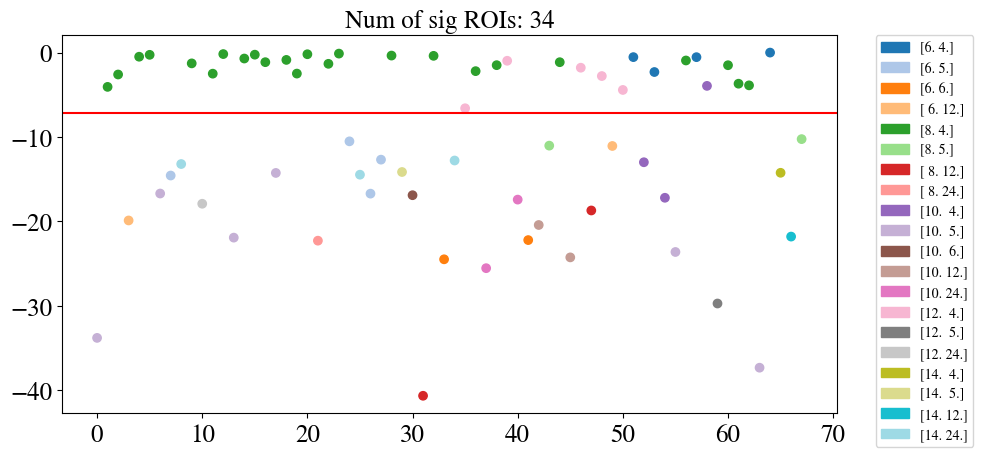

In [155]:
unique_coms = np.unique(sel_Nlams_mse, axis=0)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_coms)));
point_colors = [ colors[np.abs(unique_coms - val).sum(axis=-1)==0].squeeze() for val in sel_Nlams_mse];

log_pvs = chi2.logsf(T_vs, df=chi_df);

plt.title(f"Num of sig ROIs: {np.sum(log_pvs<log_cv):.0f}")
plt.scatter(x=np.arange(68), y=log_pvs, c=point_colors)
plt.axhline(y=log_cv, color="red")

patches = [mpatches.Patch(color=colors[np.abs(unique_coms - val).sum(axis=-1)==0].squeeze(), label=str(val)) for val in unique_coms]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=1, fontsize=10)


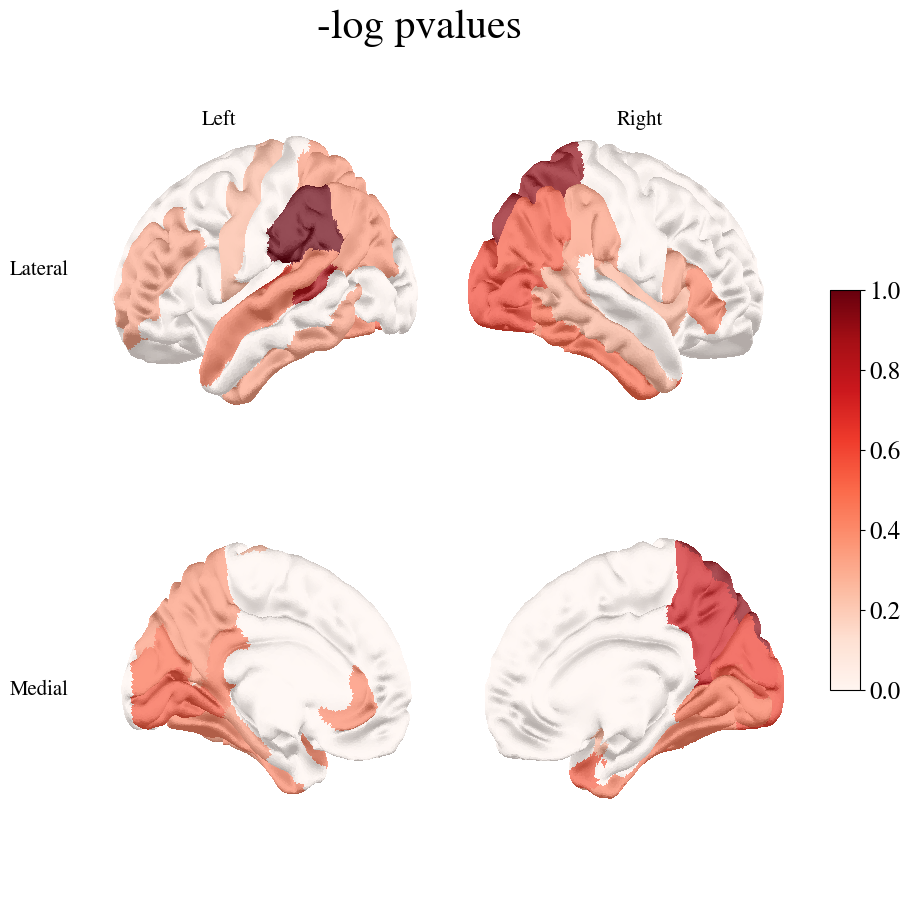

In [156]:
vec = -log_pvs
vec = (vec-vec.min())/(vec.max()-vec.min())
vec[log_pvs>=np.log(0.05/68)] = 0
#vec[log_pvs>=np.sort(log_pvs)[25]] = 0
cmap = "Reds"
fig = _brain_plot(vec, cmap=cmap);
#plt.savefig(FIG_ROOT/f"{SAVED_FOLDER}_pval_brain_plot_mae_more.jpg")

### CI

In [157]:
# select the results
num_sig = np.sum(log_pvs<log_cv)
sorted_idxs = np.argsort(log_pvs);
sig_list = []
for ix in trange(68):
    roi_sel = sorted_idxs[ix];
    fil = paras.save_dir/f"seed-0_lam-{sel_Nlams_mse[roi_sel, 1]*1000:.0f}_N-{sel_Nlams_mse[roi_sel, 0]:.0f}_roi-{roi_sel}.pkl"
    res_sel = load_pkl(fil, verbose=False);
    
    opt_sel = res_sel[0][0];
    paras_sel = res_sel[-1];
    betas_sel = paras_sel.basis_mat @  opt_sel.Gamk;betas_sel.shape
    beta_est = betas_sel[:, 0]
    cov_mat = _obt_covmat(res_sel);
    cov_mat_beta = paras_sel.basis_mat @ cov_mat @ paras_sel.basis_mat.T;
    
    lows = beta_est - np.sqrt(np.diag(cov_mat_beta))*1.96
    ups = beta_est + np.sqrt(np.diag(cov_mat_beta))*1.96
    
    bds = _get_sig_bds(lows, ups)
    sig_list.append(1-np.bitwise_and(lows<=0, ups>=0).numpy())
    
sig_list = np.array(sig_list)
sorted_rois = rois[sorted_idxs]
sorted_pvs = np.exp(log_pvs[sorted_idxs]);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:16<00:00,  4.02it/s]


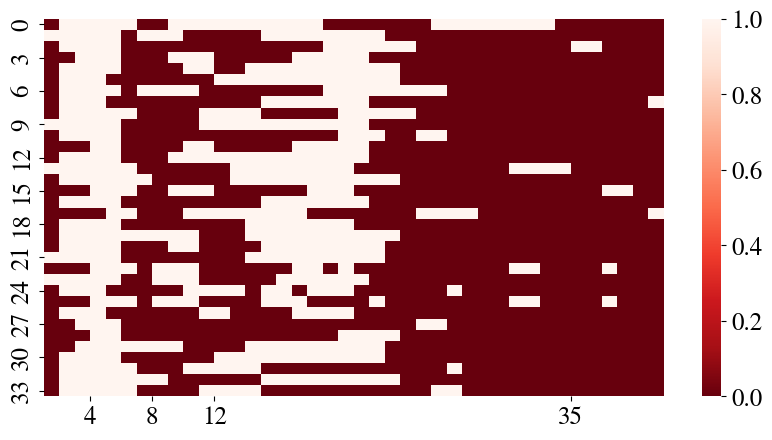

In [158]:
sns.heatmap(sig_list[:num_sig], cmap="Reds_r")
plt.xticks(cut_pts, bands_cut.pts);

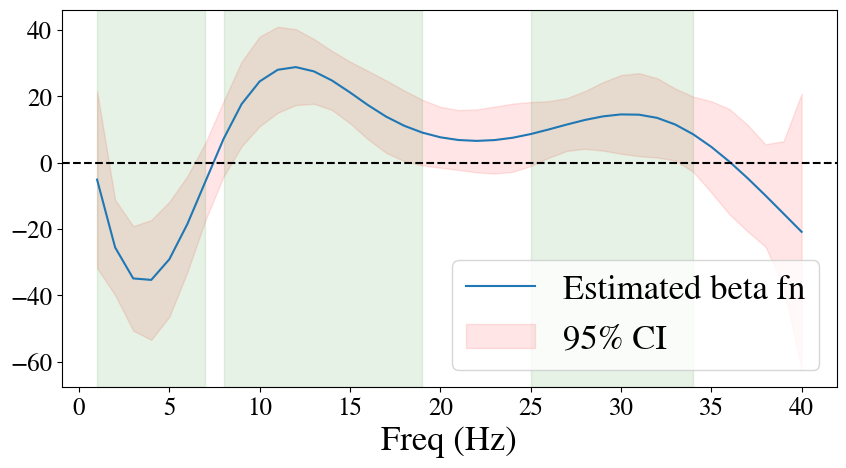

In [160]:
if not RUN_PYTHON_SCRIPT:
    roi_sel = sorted_idxs[0];
    fil = paras.save_dir/f"seed-0_lam-{sel_Nlams_mae[roi_sel, 1]*1000:.0f}_N-{sel_Nlams_mae[roi_sel, 0]:.0f}_roi-{roi_sel}.pkl"
    res_sel = load_pkl(fil, verbose=False);
    
    opt_sel = res_sel[0][0];
    paras_sel = res_sel[-1];
    betas_sel = paras_sel.basis_mat @  opt_sel.Gamk;betas_sel.shape
    beta_est = betas_sel[:, 0]
    cov_mat = _obt_covmat(res_sel);
    cov_mat_beta = paras_sel.basis_mat @ cov_mat @ paras_sel.basis_mat.T;
    
    lows = beta_est - np.sqrt(np.diag(cov_mat_beta))*1.96
    ups = beta_est + np.sqrt(np.diag(cov_mat_beta))*1.96
    
    bds = _get_sig_bds(lows, ups)
    
    freq_data_sel = all_data.X[:, roi_sel];
    plt.plot(paras.freqs, beta_est, label="Estimated beta fn")
    plt.fill_between(paras.freqs, lows, ups, color="red", alpha=0.1, label="95% CI")
    
    if False:
        freq_data_sel_AD = freq_data_sel[grp_idxs=="AD"].mean(axis=0)
        freq_data_sel_ctrl = freq_data_sel[grp_idxs=="Ctrl"].mean(axis=0)
        plt.plot(paras.freqs, freq_data_sel_AD-freq_data_sel_ctrl, label="AD-Ctrl")
    
    y_min, y_max = plt.ylim()
    for bd in bds: 
        x1, x2 = paras.freqs[bd[0]], paras.freqs[bd[1]]
        plt.fill_betweenx([y_min, y_max], x1=x1, x2=x2, color='green', alpha=0.1)
    plt.axhline(y=0, ls="--", color="black")
    plt.ylim([y_min, y_max])
    plt.xlabel("Freq (Hz)")
    plt.legend()

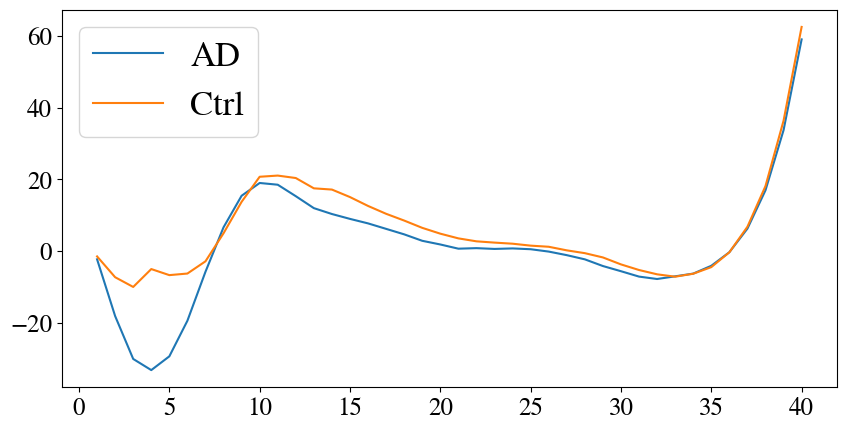

In [161]:
betaxs_sel = freq_data_sel * betas_sel[:, 0];
betaxs_sel_AD = betaxs_sel[grp_idxs=="AD"].mean(axis=0)
betaxs_sel_ctrl = betaxs_sel[grp_idxs=="Ctrl"].mean(axis=0)
plt.plot(paras.freqs, betaxs_sel_AD, label="AD")
plt.plot(paras.freqs, betaxs_sel_ctrl, label="Ctrl")
plt.legend()